# "Particulate Matter Pollution (PM10) prediction".


## Project description:

    PM10 are small airborne particles with a diameter of 10 micrometer or less. As they are so small, they are especially adverse for health since they penetrate deep into our lungs.

    We want to predict PM10 pollution measured at selected air monitoring stations 24 hours in advance. 


## Contributors
    Anke Schürmann
    Friedrich Kerchnawe
    Philipp Jordt

## Photo

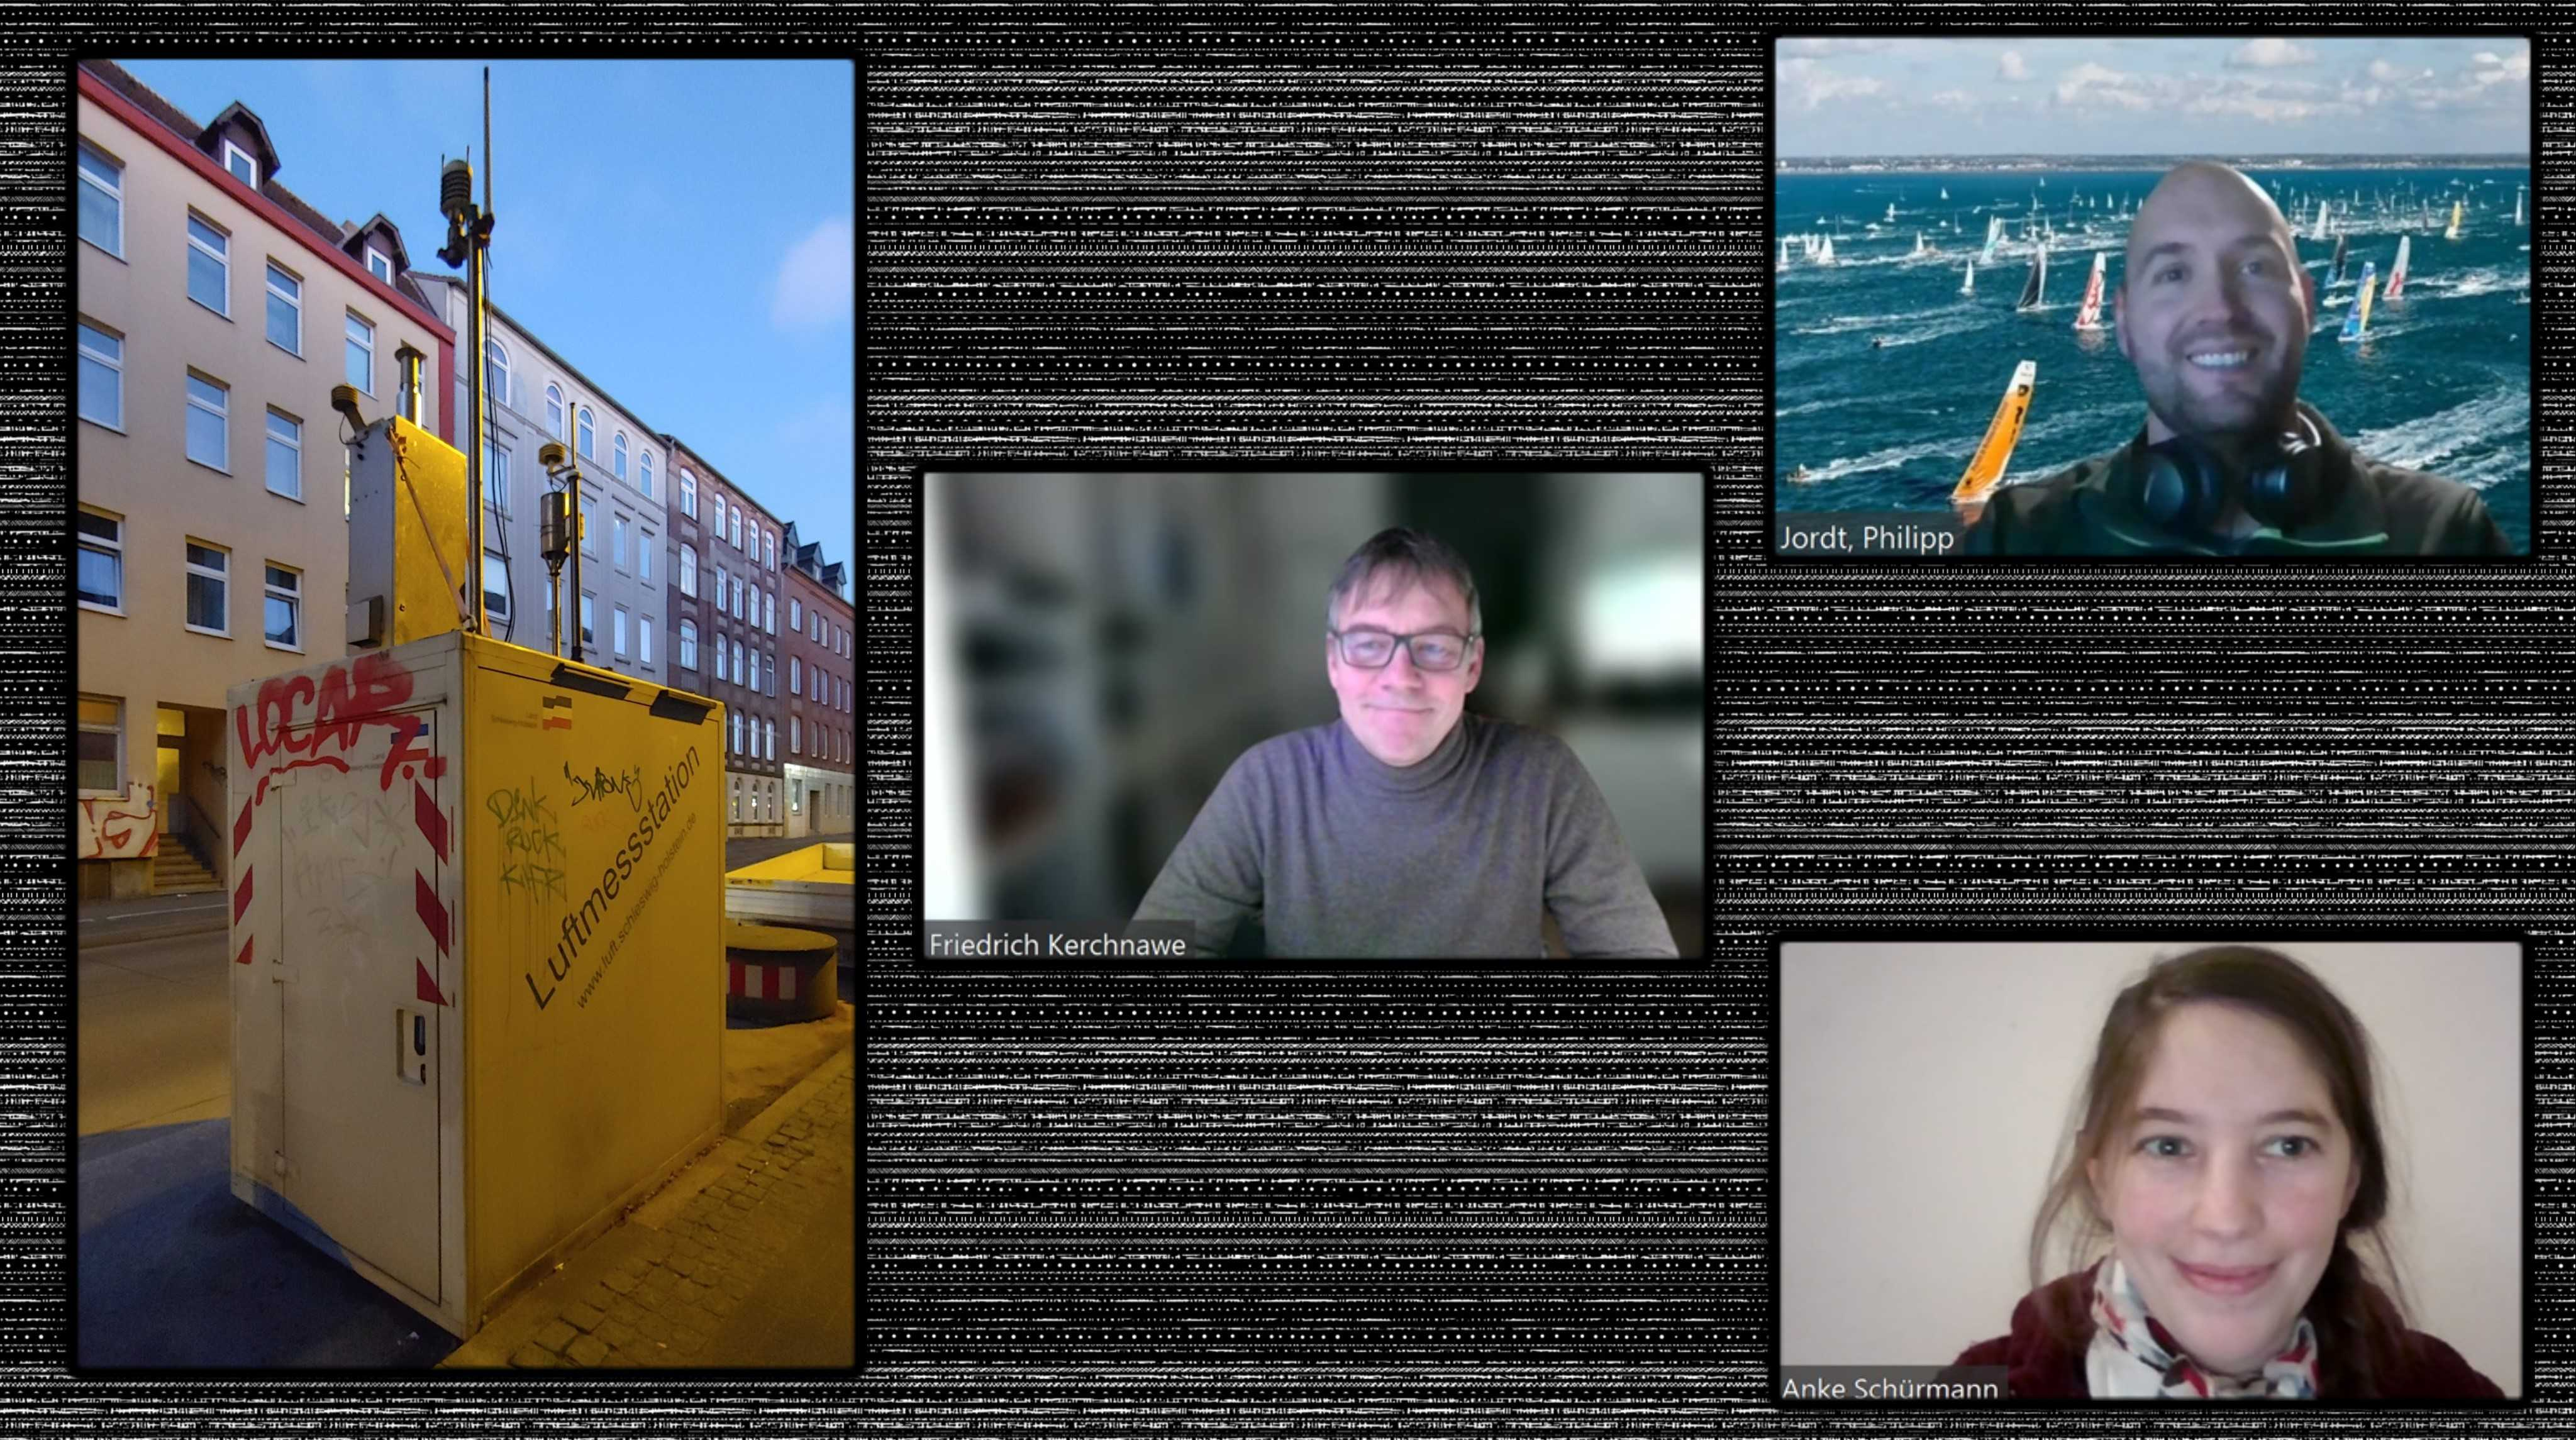

## Assessment critera
As a quantitative criterion, we have decided for Mean Absolute Percentage Error (MAPE). 

A scatter plot which shows the target values versus predictions visualizes outliers, which may hide behind a good MAPE. A perfect prediction would follow the green diagonal line.

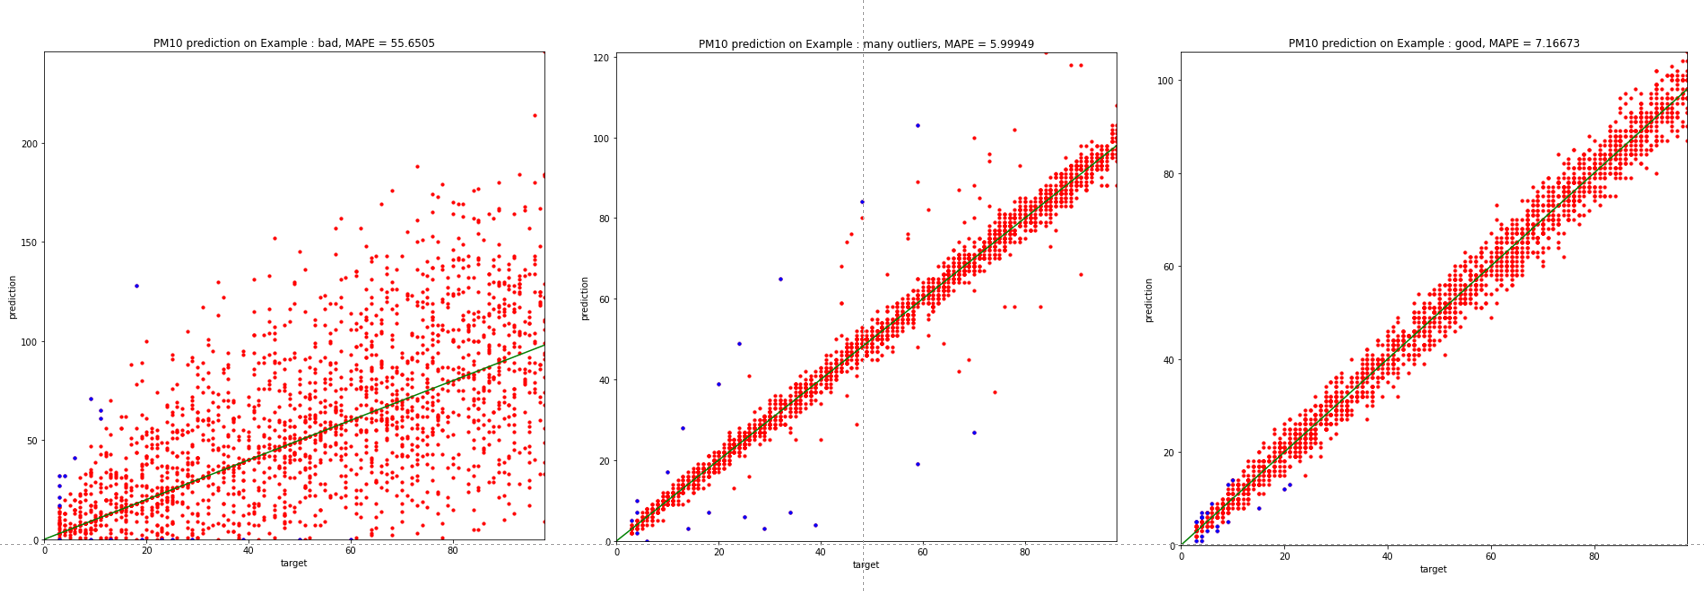

On a timeline we plot target values versus predictions visualizing how the predictions pick up seasonality of the data. 

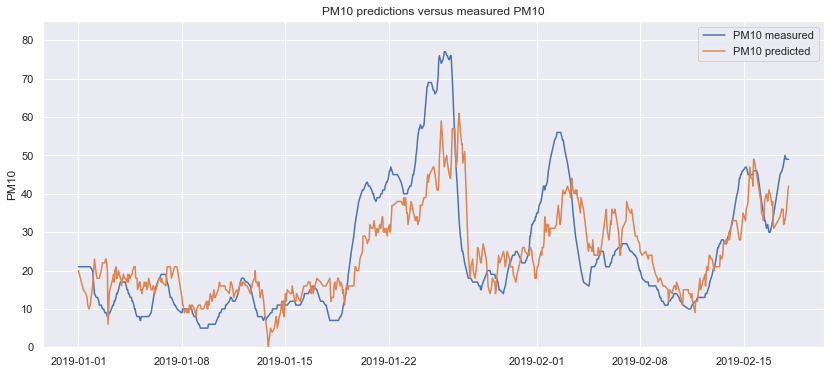

## Solution aproach

The machine should be trained with weather data and PM10 pollution data from the past. On the basis of weather forecast data, the machine should predict PM10 pollution. The machine could be trained with additional data, such as Holidays and Date/Time features.
Because we all live in Kiel, we wanted to work with data from a local air monitoring station. Unfortunately, the data from the Theodor-Heuss Ring are not available. So we decided to use the air monitoring station in the Bahnhofstr. in Kiel.
In order to avoid influences from the Corona Lock Downs on our project, we decided to work only on the basis of data before 2020. PM10 values from Bahnhofstr. are available from the beginning of 2016.

## Data sources and features

### PM10 Data

   PM10 data on an hourly basis is available from the "Bundesumweltamt":
    https://updatedeutschland.org/wpcontent/uploads/2021/03/Schnittstellenbeschreibung-Luftdaten_API_2019_09_12.pdf
    
   Download for the air monitoring station "Bahnhofstr. Kiel":        
    https://www.umweltbundesamt.de/api/air_data/v2/airquality/csv?station=1554&date_from=2016-01-01&time_from=1&time_to=24&date_to=2019-12-31&time_to=24&lang=de


### Weather Data
  Weather data on an hourly basis is available from the "Deutscher Wetterdienst":  
    https://www.dwd.de/DE/leistungen/klimadatendeutschland/klarchivstunden.html

  Station list of the 78 measuring stations:   
    https://www.dwd.de/DE/leistungen/klimadatendeutschland/stationsuebersicht.html?nn=16102&lsbId=536016

  Further information on climate data - hourly values:   
    https://www.dwd.de/DE/leistungen/klimadatendeutschland/beschreibung_stundenwerte.html?nn=16102&lsbId=536016
    
We selected the measuring station Kiel Holtenau, as this is the nearest station to Bahnhofstr. Kiel

Predictions of weather data for 8 days in advance on an hourly basis are available from "wetter.com":   
https://www.wetter.com/deutschland/wetterstation-kiel-holtenau/DEXXX0015.html   
Data available from this source determinded also the weather features we selected for training.


### Date/Time Data
We have manually compiled public holidays from the following source into a csv file:   
http://www.feiertage-newsletter.de/deutschland/uebersicht-2019.html

We have manually compiled school holidays into a csv file from the following source.
https://www.schulferien.org/Kalender_mit_Ferien/kalender_2019_ferien_Schleswig_Holstein.html

For predictions we can use the same data sources.


### Summary of available Features

    "Datum"     - datetime (Year, Month, Day, Hour)
    "PM10"      - PM10 measured (µg/m³) (NOW)
    "Schulfrei" - school free (1/0)
    "Feiertag"  - public holidays (1/0)
    "F"         - wind velocity (in m/sec
    "D"         - wind direction (in deg)
    "R1"        - rain amount per hour (in mm)"
    "TT_STD"    - air temperature at 2m height (in °C)
    "RF_STD"    - relative humidity (in %)
    "V_N"       - degree of coverage of all clouds (in eights)
    "PP_TER"    - air pressure (in hpa)

## Imports

In [1]:
import collect_data
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
import pandas as pd
import datetime
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

## Data Analysis

In [2]:
df = collect_data.make_PM10_df("Luftqualitaet_DESH027_Kiel-Bahnhofstr.csv", "Wetter_Holtenau")

In [3]:
df_PM10 = df[['Datum', 'PM10']]
df_PM10['year'] = pd.DatetimeIndex(df_PM10['Datum']).year
df_PM10['month'] = pd.DatetimeIndex(df_PM10['Datum']).month
df_PM10['day'] = pd.DatetimeIndex(df_PM10['Datum']).day
df_PM10['hour'] = pd.DatetimeIndex(df_PM10['Datum']).hour
df_PM10["Date"] = pd.to_datetime(df_PM10[['year', 'month', 'day']])
df_PM10["day_of_week"] = df_PM10["Datum"].apply(lambda x: x.isocalendar().weekday)

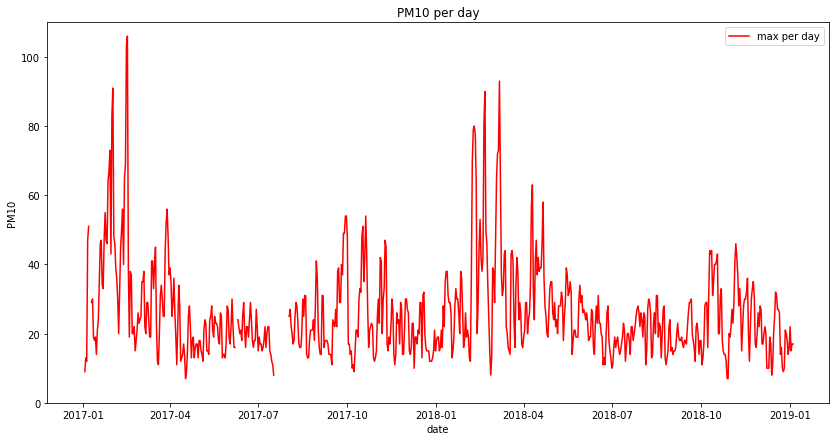

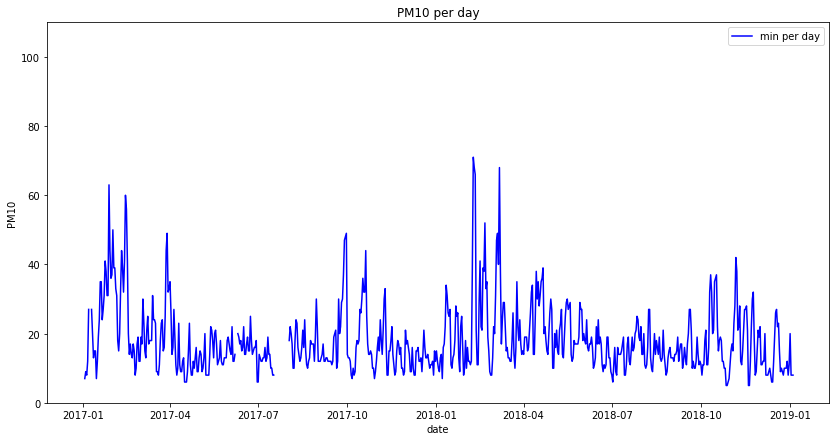

In [4]:
df_PM10_max = df_PM10[['Date','PM10']].groupby('Date').max()
df_PM10_min = df_PM10[['Date','PM10']].groupby('Date').min()
df_PM10_max = df_PM10_max[366:1100]
df_PM10_min = df_PM10_min[366:1100]

fig = plt.figure(figsize=(14,7))
plt.plot(df_PM10_max.index, df_PM10_max['PM10'], label='max per day', color = 'r')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('PM10')
plt.title('PM10 per day')
plt.ylim(0, 110)
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(df_PM10_min.index, df_PM10_min['PM10'], label='min per day', color = 'b')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('PM10')
plt.title('PM10 per day')
plt.ylim(0, 110)
plt.show()

<AxesSubplot:xlabel='year', ylabel='PM10'>

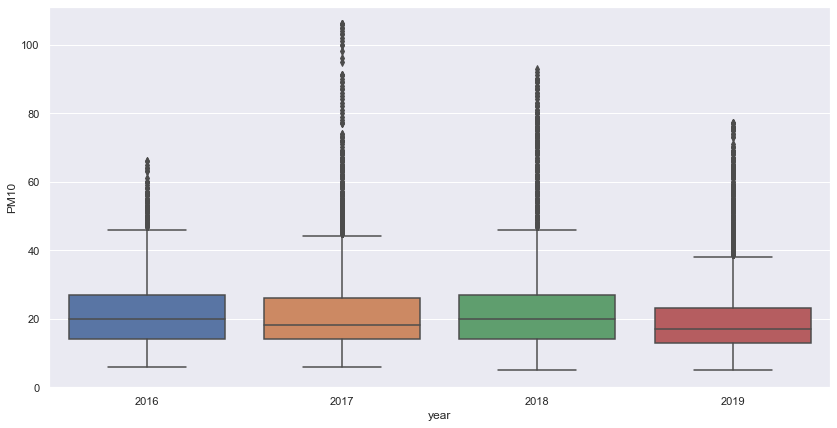

In [5]:
sns.set(rc={'figure.figsize':(14,7)})
sns.boxplot(x='year', y='PM10', data = df_PM10)

<AxesSubplot:xlabel='month', ylabel='PM10'>

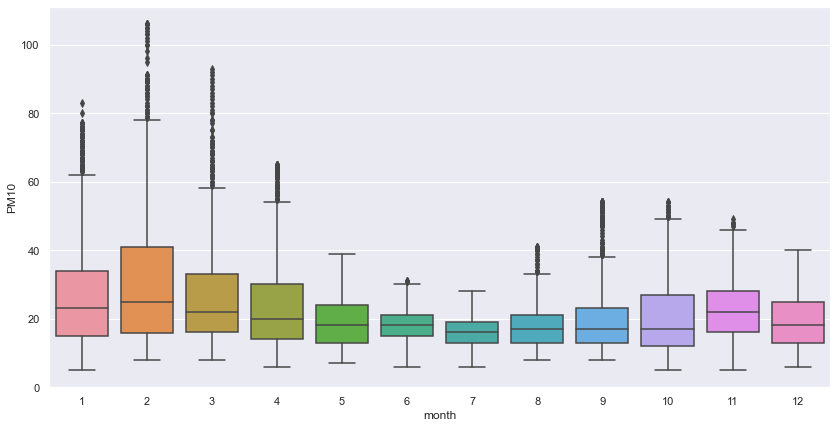

In [6]:
sns.boxplot(x='month', y='PM10', data = df_PM10)

<AxesSubplot:xlabel='day_of_week', ylabel='PM10'>

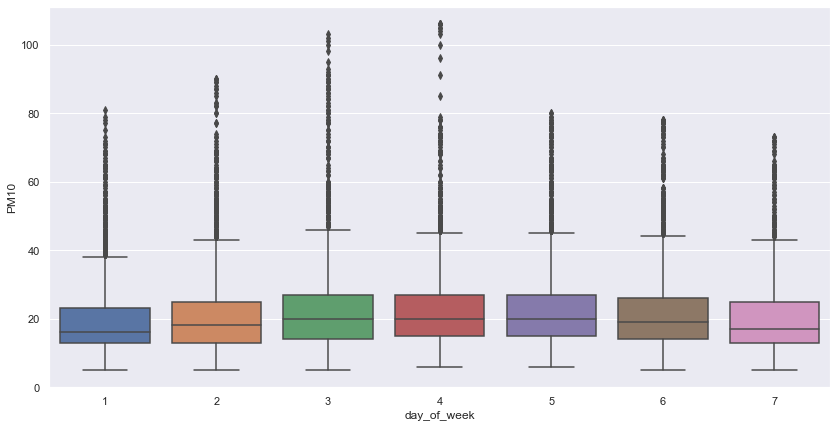

In [7]:
sns.boxplot(x='day_of_week', y='PM10', data = df_PM10)

<AxesSubplot:xlabel='hour', ylabel='PM10'>

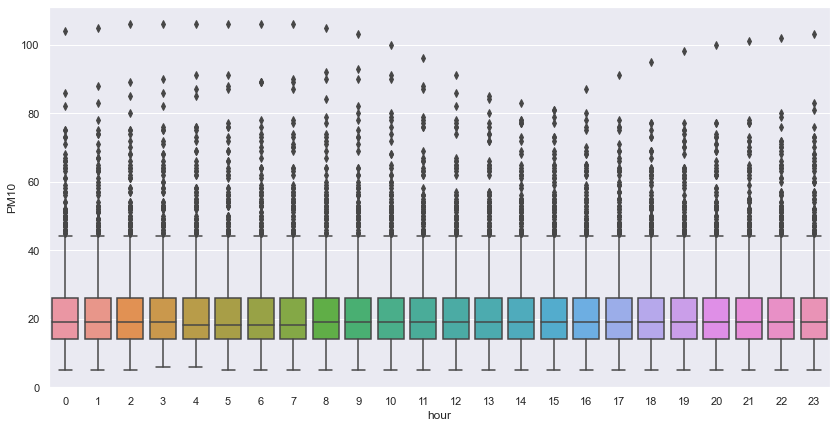

In [8]:
sns.boxplot(x='hour', y='PM10', data = df_PM10)

In [9]:
df1 = df[collect_data.w_cols_select + ["PM10", "Datum"]]

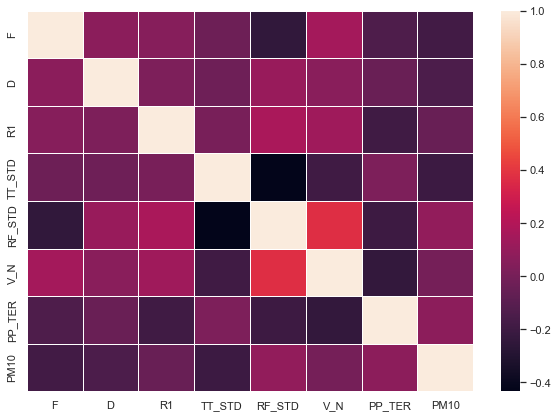

In [10]:
# Correlation matrix with heatmap
corr = df1.corr()
fig = plt.figure(figsize=(10,7))
_ = sns.heatmap(corr, linewidths=.5)

### Missing Data

In [11]:
cols = collect_data.w_cols_select[::-1] + ["PM10", "Datum"]
data_summary = list()

for col in list(cols[::-1]):
    n = df[col].nunique()
    if type('str') != type(df[col][1]):
        mi = df[col].min()
        ma = df[col].max()
        av = df[col].mean()
    else:
        mi = ma = av = np.NaN

    try:
        md = list(df[col].mode())[0]
    except:
        md = np.NaN
        
    na = df["Datum"][df[col].isnull()].count()
    data_summary.append([col, n, mi, ma, na, av, md ])

,column,description
8,F,wind velocity (in m/sec)
9,D,wind direction (in deg)
16,R1,rain amount per hour (in mm)
24,TT_STD,air temperature at 2m height (in °C)
25,RF_STD,relative humidity (in %)
29,V_N,degree of coverage of all clouds (in eights)
31,PP_TER,air pressure (in hpa)


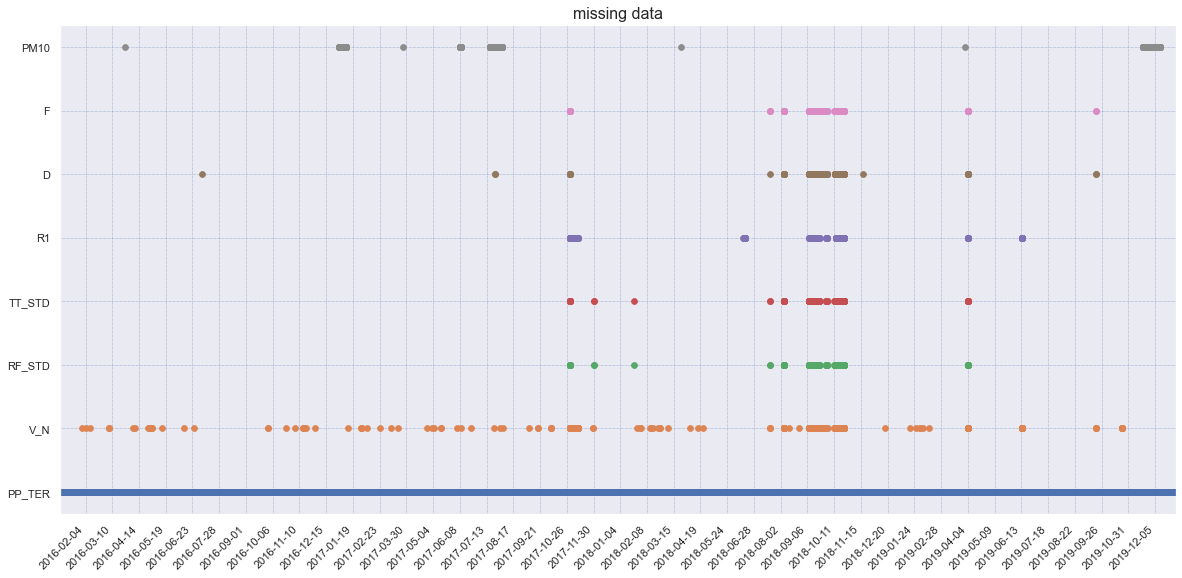

In [12]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
df.Datum = pd.date_range(df.Datum.min(), df.Datum.max(), freq = "H")
df_w = df[cols]

i = 1
for col in list(cols):
    l = df_w.Datum[df_w[col].isnull()]
    l1 = pd.DataFrame({"Datum": l, col: [i]*l.size })
    plt.scatter(l1.Datum, l1[col], linewidth=.7)
    i = i+1

loc = plticker.MultipleLocator(base=35) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
fig.autofmt_xdate(rotation=45)
y_locator = FixedLocator(range(1,i))
y_formatter = FixedFormatter(cols)
ax.yaxis.set_major_formatter(y_formatter)
ax.yaxis.set_major_locator(y_locator)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(linestyle='dotted', linewidth=.5, color ='b')
plt.title('missing data', fontsize = 16)
plt.margins(x=0)

descriptions = collect_data.get_description()
descriptions = descriptions[descriptions['column'].isin(collect_data.w_cols_select)]
descriptions[["column", "description"]].head(10)

In [13]:
pd.DataFrame(data_summary, columns = ("feature", "unique_values", 
                                      "min", "max", "NaNs", "mean", "mode")).head(100)

,feature,unique_values,min,max,NaNs,mean,mode
0,Datum,35064,2016-01-01 00:00:00,2019-12-31 23:00:00,0,2017-12-31 11:30:00,2016-01-01 00:00:00
1,PM10,99,5.0,106.0,1096,21.415538,13.0
2,F,141,0.0,14.5,431,3.75012,2.4
3,D,36,10.0,360.0,420,196.832641,260.0
4,R1,79,0.0,25.9,580,0.082859,0.0
5,TT_STD,413,-9.2,34.4,428,9.998455,6.1
6,RF_STD,699,16.3,100.0,428,81.11357,100.0
7,V_N,9,0.0,8.0,793,5.035161,8.0
8,PP_TER,558,974.4,1039.6,29775,1011.015069,1012.0


## Data preparation

### Selection of air monitoring station, weather station and time frame

 - air monitoring station: DESH027_Kiel-Bahnhofstr
 - weather station: Kiel Holtenau
 - time frame: 2016-01-01 - 2019-12-31

### Missing Data
We tested few different simple methods and used the best mix we could find:

    Base model:  
        forward fill for all features  
    NN Model-5  
        forward fill for air pressure, wind direction and clouds  
        dropna on all other data    

### Date/Time features
The datetime feature has been divided into the following features

- year
- month
- day of week
- hour

### special treatment
Wetter.com offers in its weather forecast the wind direction for the 8 main directions (north, northwest, west, etc.). Therefore, the wind direction provided by the weather station (feature "D") was coded to these 8 main directions.

For some weather features, special values (e.g., -999) are used in the data sources to indicate "unobserved" values. We have converted these values to NaN.

### One-Hot Encoding
following features have been hot-encoded:

- month
- day of week
- hour
- wind direction
- bank holidays



## Helper Functions

In [14]:
def mape_1(y_true, y_pred):  
    return 100 * np.mean(np.abs(y_true - y_pred) / y_true)

In [15]:
def plot_assessment(predictions, targets, title = "unknown data"):
    top = pd.DataFrame( { 'measured': list(targets), 
                          'predicted': list(predictions) })
    top["percentage_error"] = (predictions - targets) / targets * 100
    top_m = top.sort_values(by=['percentage_error'], ascending=True).head(10)
    top_p = top.sort_values(by=['percentage_error'], ascending=False).head(10)

    start = 0
    n = len(targets)
    maxPM10 = max(predictions[start:start+n].max(), targets[start:start+n].max())

    plt.rcParams["figure.figsize"] = (10,10)
    plt.plot([0,maxPM10],[0,maxPM10],color = 'g')
    plt.scatter(targets[start:start+n], predictions[start:start+n],s=10 ,color = 'r')
    plt.scatter(top_m["measured"], top_m["predicted"],s=10, color = 'b')
    plt.scatter(top_p["measured"], top_p["predicted"],s=10, color = 'b')

    plt.ylabel('prediction')
    plt.xlabel('target')
    plt.xlim(xmin = 0, xmax = max(targets))
    plt.title("PM10 prediction on " + title + ", MAPE = {:n}".format(mape_1(targets, predictions)))
    plt.margins(0,0)
    plt.show()

In [16]:
def plot_learning_curve(loss, val_loss):
    plt.rcParams["figure.figsize"] = (20,10)
    fig1, ax1 = plt.subplots()
    plt.plot(range(1, len(loss)+1),loss)
    plt.plot(range(1, len(val_loss)+1),val_loss)
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.title("val_loss = {:n} after {:n} epochs".format(val_loss[-1], len(val_loss)))
    plt.legend(['loss', 'val_loss'])
    plt.show()

    return

## Base Model - Linear Regressen

    predict the PM10 value in 24hours in advance   
    
    Features:    
    
        - Date/Time to be predicted  
        - predicted weather data for the DateTime to be predicted  
        - bank holidays for the day to be predicted  
        - school free for the day to be predicted  
        - calculated from measured PM10 values 24-39 hours before prediction DateTime:  
            - rolling_mean     
            - rolling_max   
            - rolling_min   
        - measured PM10 values for 14 days before prediction DateTime at the same hour   

### load data

In [17]:
df_b = collect_data.prep_data_model_0("Luftqualitaet_DESH027_Kiel-Bahnhofstr.csv", 
                                    "Wetter_Holtenau",
                                    bundesland = 'SH')

df_b = df_b.drop(["year", "Schulfrei"], axis = 1)
df_b = df_b.fillna(method = 'ffill')
df_b = df_b.fillna(method = 'bfill')

df_b.shape

(35064, 76)

In [18]:
# Lag features
for i in range(24,24*14,24):
    lag_i = 'PM10_' + str(i)
    df_b[lag_i] = df_b.PM10.shift(i)

# Rolling window
w_size = 6
df_b['rolling_mean'] = df_b.PM10.rolling(window=w_size).mean()
df_b['rolling_max'] = df_b.PM10.rolling(window=w_size).max()
df_b['rolling_min'] = df_b.PM10.rolling(window=w_size).min()

df_b['rolling_mean']= df_b['rolling_mean'].shift(24)
df_b['rolling_max']= df_b['rolling_max'].shift(24)
df_b['rolling_min']= df_b['rolling_min'].shift(24)

In [19]:
df_b = df_b.dropna(how='any', inplace=False)

In [20]:
list(df_b.columns)

['Datum',
 'PM10',
 'F',
 'R1',
 'TT_STD',
 'RF_STD',
 'V_N',
 'PP_TER',
 'monday',
 'tuesday',
 'wednesday',
 'thursday',
 'friday',
 'saturday',
 'sunday',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 '1. Advent',
 '1. Weihnachtstag',
 '2. Advent',
 '2. Weihnachtstag',
 '3. Advent',
 '4. Advent',
 'Christi Himmelfahrt',
 'Heiligabend',
 'Karfreitag',
 'Maifeiertag',
 'Neujahr',
 'Ostermontag',
 'Ostern',
 'Pfingstmontag',
 'Reformationstag',
 'Silvester',
 'Tag der Deutschen Einheit',
 'wind_E',
 'wind_N',
 'wind_NE',
 'wind_NW',
 'wind_S',
 'wind_SE',
 'wind_SW',
 'wind_W',
 'PM10_24',
 'PM10_48',
 'PM10_72',

### create training, validation and test data sets
Data has been separated to  training- and validationdata sets:  
   - training data set: all data except last 365 days  
   - validation data set: all data from last 365 days  

In [21]:
train_Y, train_X,         \
val_Y, val_X,             \
test_Y, test_X,           \
df_train, df_val, df_test = collect_data.build_data_arrays(df_b)

In [22]:
df_val.shape

(4380, 92)

### Linear Regression

In [23]:
model_base = LinearRegression()  # create object for the class
model_base.fit(train_X, train_Y)  # perform linear regression

LinearRegression()

### predict training and validation data

In [24]:
pred_val_Y_B = np.round(model_base.predict(val_X))  # make predictions
pred_train_Y_B = np.round(model_base.predict(train_X))  # make predictions

### model assessment

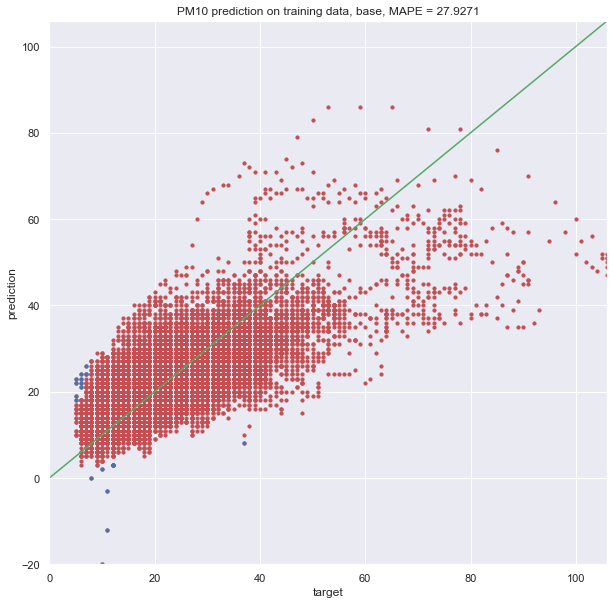

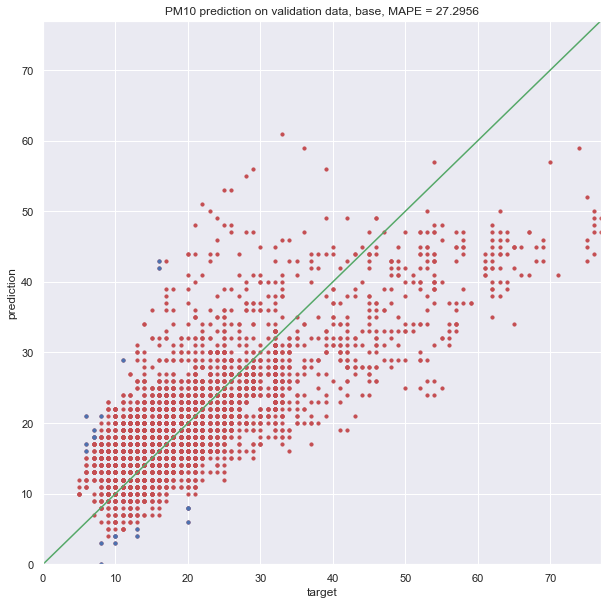

In [25]:
plot_assessment(pred_train_Y_B, train_Y, title = "training data, base")
plot_assessment(pred_val_Y_B, val_Y, title = "validation data, base")

In [26]:
df_val.shape

(4380, 92)

In [27]:
len(val_Y)

4380

In [28]:
dval_B = df_val[["Datum", "PM10"]].copy()
dval_B["Prediction"] = pred_val_Y_B
dval_B = dval_B.set_index(["Datum"]).sort_index()

In [29]:
i = 0

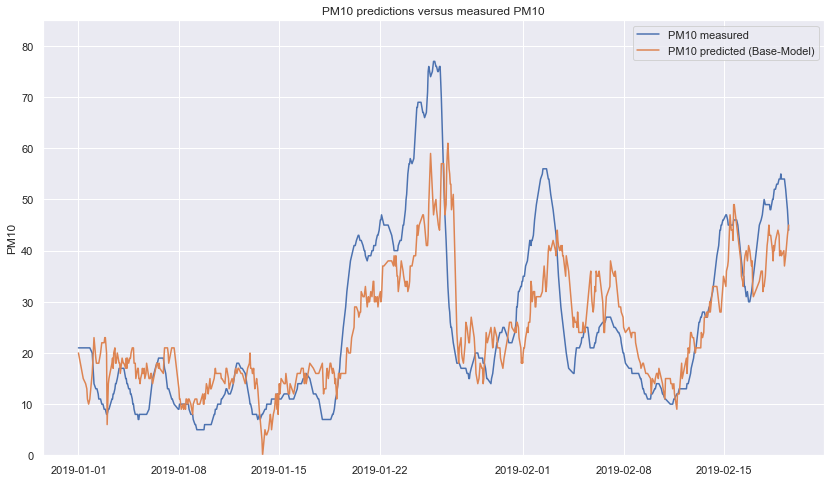

In [30]:
dvali = dval_B[i:i + 622]

fig = plt.figure(figsize=(14,8))
plt.plot(dvali.index, dvali["PM10"], label='PM10 measured')
plt.plot(dvali.index, dvali["Prediction"], label='PM10 predicted (Base-Model)')
#plt.plot(dval.index, df_val["PM10"], label='Validation')
#plt.plot(errors_df.index, errors_df['pred_qty'], label='Prediction')
plt.ylim(0, 85)
plt.legend(loc='best')
plt.xlabel(' ')
plt.ylabel('PM10')
plt.title('PM10 predictions versus measured PM10')
plt.show()

i += 620
if i > dval_B.shape[0]:
    i = 0

## Neural Network "model_5"
    predict the PM10 value 24hours in advance   
    
    Features:    
    
        - Date/Time to be predicted  
        - predicted weather data for 25 hours in advance of prediction DateTime
        - bank holidays for the day to be predicted  
        - school free for the day to be predicted  
        - calculated from measured PM10 values 24-39 hours before prediction DateTime:  
            - rolling_mean     
            - rolling_max   
            - rolling_min   
        - measured PM10 values for 14 days before prediction DateTime at the same hour 

### load data

In [31]:
df_5_K = collect_data.prep_data_model_5("Luftqualitaet_DESH027_Kiel-Bahnhofstr.csv", "Wetter_Holtenau",
                                bundesland = 'SH', embeddings = 24)

In [32]:
df_5_K.shape

(32745, 401)

In [33]:
# Lag features
for i in range(48,24*14,24):
    lag_i = 'PM10_' + str(i)
    df_5_K[lag_i] = df_b.PM10.shift(i)

# Rolling window
w_size = 3
df_5_K['rolling_mean'] = df_5_K.PM10.rolling(window=w_size).mean()
df_5_K['rolling_max'] = df_5_K.PM10.rolling(window=w_size).max()
df_5_K['rolling_min'] = df_5_K.PM10.rolling(window=w_size).min()

df_5_K['rolling_mean']= df_5_K['rolling_mean'].shift(24)
df_5_K['rolling_max']= df_5_K['rolling_max'].shift(24)
df_5_K['rolling_min']= df_5_K['rolling_min'].shift(24)

In [34]:
df_5_K = df_5_K.dropna(how='any', inplace=False)

In [35]:
i = 0
for el in list(df_5_K.columns):
    print ("{:n}   ".format(i) + el)
    i +=1

0   Datum
1   PM10
2   Schulfrei
3   F
4   R1
5   TT_STD
6   RF_STD
7   V_N
8   PP_TER
9   year
10   monday
11   tuesday
12   wednesday
13   thursday
14   friday
15   saturday
16   sunday
17   month_1
18   month_2
19   month_3
20   month_4
21   month_5
22   month_6
23   month_7
24   month_8
25   month_9
26   month_10
27   month_11
28   month_12
29   hour_0
30   hour_1
31   hour_2
32   hour_3
33   hour_4
34   hour_5
35   hour_6
36   hour_7
37   hour_8
38   hour_9
39   hour_10
40   hour_11
41   hour_12
42   hour_13
43   hour_14
44   hour_15
45   hour_16
46   hour_17
47   hour_18
48   hour_19
49   hour_20
50   hour_21
51   hour_22
52   hour_23
53   1. Advent
54   1. Weihnachtstag
55   2. Advent
56   2. Weihnachtstag
57   3. Advent
58   4. Advent
59   Christi Himmelfahrt
60   Heiligabend
61   Karfreitag
62   Maifeiertag
63   Neujahr
64   Ostermontag
65   Ostern
66   Pfingstmontag
67   Reformationstag
68   Silvester
69   Tag der Deutschen Einheit
70   wind_E
71   wind_N
72   wind_NE
73   wi

### create training, validation and test data sets

In [36]:
train_Y, train_X, val_Y, val_X, test_Y, test_X, df_train, df_val, df_test = \
collect_data.build_data_arrays(df_5_K, split = 340*24, f = 0.5, seed = 42, shuffle_train = True)

### define NN model

In [37]:
from tensorflow.keras.layers import PReLU
para_relu = PReLU()
act = tf.keras.layers.LeakyReLU(alpha=0.3)

def model_define(nodes_h1 = 96, nodes_h2 = 32, nodes_h3 = 0, nodes_h4 = 0,  nodes_h5 = 0, 
                 nodes_h6 = 0, nodes_h7 = 0, nodes_h8 = 0, nodes_h9 = 0, nodes_h10 = 0): 
       
    # Normalization layer 
    normalizer = preprocessing.Normalization()
    normalizer.adapt(train_X)
    inputs = tf.keras.Input(shape=[train_X.shape[1]])
    x = normalizer(inputs)
    
    # hidden layers 
    if nodes_h1 > 0:
        x = Dense(nodes_h1, activation=act,  #)(x) 
                  kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
    # drop out layer
        x = tf.keras.layers.Dropout(.2)(x)
    if nodes_h2 > 0:
        x = Dense(nodes_h2, activation=act,  #)(x)
                  kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
    # drop out layer
        x = tf.keras.layers.Dropout(.2)(x)
    if nodes_h3 > 0:
        x = Dense(nodes_h3, activation=act,  #)(x) 
                 kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
    if nodes_h4 > 0:
        x = Dense(nodes_h4, activation=act)(x)
    if nodes_h5 > 0:
        x = Dense(nodes_h5, activation=act)(x)
    if nodes_h6 > 0:
        x = Dense(nodes_h6, activation=act)(x)
    if nodes_h7 > 0:
        x = Dense(nodes_h7, activation=act)(x)
    if nodes_h8 > 0:
        x = Dense(nodes_h8, activation=act)(x)
    if nodes_h9 > 0:
        x = Dense(nodes_h9, activation=act)(x)
    if nodes_h10 > 0:
        x = Dense(nodes_h10, activation=act)(x)
        
    # Output layer
    x = tf.keras.layers.Dense(1)(x)
    
    # PM10 are in the range 0-110, help learning by scaling activations in the NN to 0-1
    output = tf.keras.layers.Lambda(lambda x: x * 110.0)(x)
    
    # Model definition
    model = tf.keras.Model(inputs, output)
    
    return model

In [38]:
def scheduler(epoch, lr):
    return lr * decent_l_r

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### set hyperparameters
    
    best for model_6:
        embeddings = 48, 
        [[1.75e-05, 0.96, 1024, 512, 256, 256, 128, 128, 64, 32, 8, 0]], 
        MAPE = 8.80471 at epoch 31
        optimizer=tf.keras.optimizers.SGD(learning_rate=start_l_r, momentum=0.98)

In [39]:
import random
hypa = []

for i in range(0,1):
    hypa.append([0,0,0,0,0,0,0,0,0,0,0,0])    
    hypa[i][0] = 0.000027 # start learning rate      random.random(0.000016, 0.000019)
    hypa[i][1] = 0.94      # learning rate decent     random.random(0.94, 0.098)
    hypa[i][2] = 220      # nodes on level           random.randint(start,end)
    hypa[i][3] = 220       # nodes on level           random.randint(start,end)
    hypa[i][4] = 100       # nodes on level           random.randint(start,end)
    hypa[i][5] = 100       # nodes on level           random.randint(start,end)
    hypa[i][6] = 50       # nodes on level           random.randint(start,end)   
    hypa[i][7] = 25       # nodes on level           random.randint(start,end)
    hypa[i][8] = 20        # nodes on level           random.randint(start,end)
    hypa[i][9] = 8        # nodes on level           random.randint(start,end)
    hypa[i][10] = 0        # nodes on level           random.randint(start,end)
    hypa[i][11] = 0        # nodes on level           random.randint(start,end)
    
hypa

[[2.7e-05, 0.94, 220, 220, 100, 100, 50, 25, 20, 8, 0, 0]]

### train the model

In [40]:
results = []

for hypa_i in range(0,len(hypa)):
    model = model_define(nodes_h1 = hypa[hypa_i][2], nodes_h2 = hypa[hypa_i][3], 
                         nodes_h3 = hypa[hypa_i][4], nodes_h4 = hypa[hypa_i][5], 
                         nodes_h5 = hypa[hypa_i][6], nodes_h6 = hypa[hypa_i][7],
                         nodes_h7 = hypa[hypa_i][8], nodes_h8 = hypa[hypa_i][9],
                         nodes_h9 = hypa[hypa_i][10], nodes_h10 = hypa[hypa_i][11])
    
    model.compile(#loss = tf.keras.losses.MeanSquaredLogarithmicError(),
                  loss = 'MAPE',
                  #loss = tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hypa[hypa_i][0]), metrics=["MAPE"])
                  #optimizer=tf.keras.optimizers.SGD(learning_rate=hypa[hypa_i][0], momentum=0.99))  #, metrics=["MAPE"])

    decent_l_r = hypa[hypa_i][1]
    history = model.fit(train_X, train_Y, epochs = 20, validation_data = (val_X, val_Y), 
                        callbacks = [callback], verbose = 1)
    
    loss = list(history.history['loss'])
    val_loss = list(history.history['val_loss'])

    mape_m = mape_1(val_Y, model.predict(val_X))
    results.append([hypa[hypa_i], loss, val_loss, model, mape_m])

Epoch 1/20
751/751 [==============================] - 5s 6ms/step - loss: 128.7724 - MAPE: 41.5225 - val_loss: 119.7249 - val_MAPE: 32.6787 - lr: 2.5380e-05
Epoch 2/20
751/751 [==============================] - 4s 5ms/step - loss: 119.0080 - MAPE: 32.1732 - val_loss: 115.3952 - val_MAPE: 28.7811 - lr: 2.3857e-05
Epoch 3/20
751/751 [==============================] - 4s 5ms/step - loss: 115.3976 - MAPE: 29.0059 - val_loss: 112.6520 - val_MAPE: 26.4928 - lr: 2.2426e-05
Epoch 4/20
751/751 [==============================] - 4s 5ms/step - loss: 112.9447 - MAPE: 27.0176 - val_loss: 111.3197 - val_MAPE: 25.6332 - lr: 2.1080e-05
Epoch 5/20
751/751 [==============================] - 4s 5ms/step - loss: 111.1520 - MAPE: 25.7026 - val_loss: 109.6816 - val_MAPE: 24.4770 - lr: 1.9815e-05
Epoch 6/20
751/751 [==============================] - 3s 5ms/step - loss: 109.6546 - MAPE: 24.6903 - val_loss: 108.4616 - val_MAPE: 23.7444 - lr: 1.8626e-05
Epoch 7/20
751/751 [==============================] - 3s 5

### Model Summary

In [41]:
selection = 0
#loss = results[selection][1]
#val_loss = results[selection][2]
model_5_K = results[selection][3]
model_5_K.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 414)]             0         
                                                                 
 normalization (Normalizatio  (None, 414)              829       
 n)                                                              
                                                                 
 dense (Dense)               (None, 220)               91300     
                                                                 
 dropout (Dropout)           (None, 220)               0         
                                                                 
 dense_1 (Dense)             (None, 220)               48620     
                                                                 
 dropout_1 (Dropout)         (None, 220)               0         
                                                             

### plot learning curve

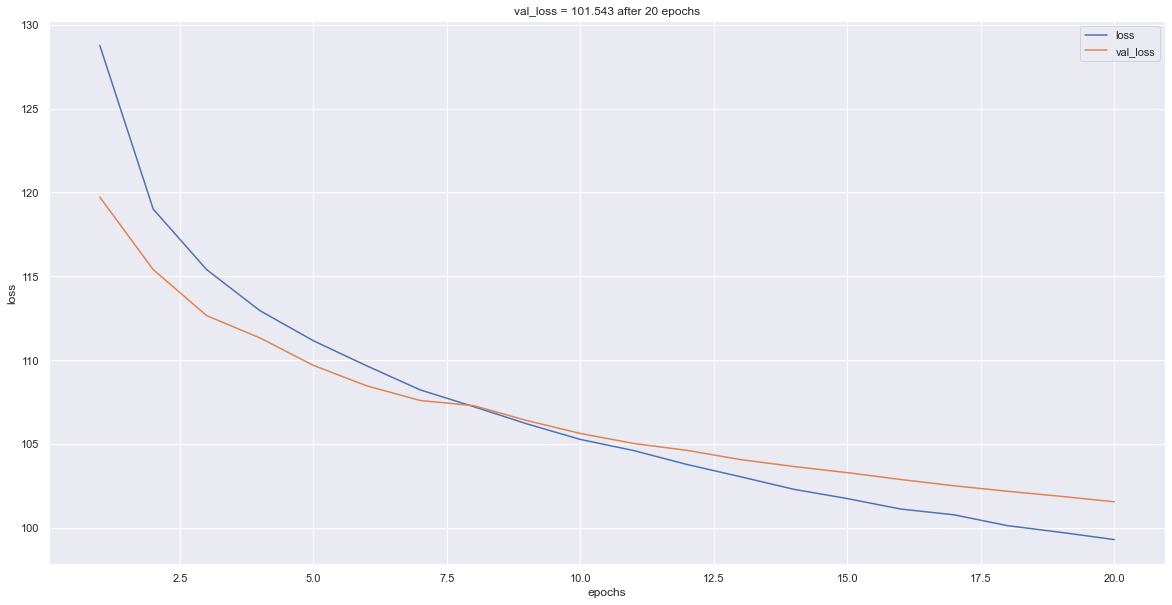

In [42]:
plot_learning_curve(loss, val_loss)

### predict training and validation data
   round the predictions to the nearest integer

In [43]:
pred_val_Y = np.round(model_5_K.predict(val_X))
pred_train_Y = np.round(model_5_K.predict(train_X))

### model assessment

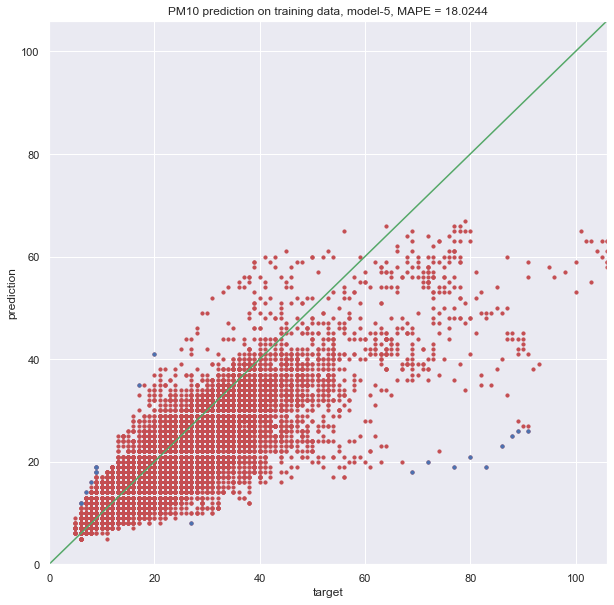

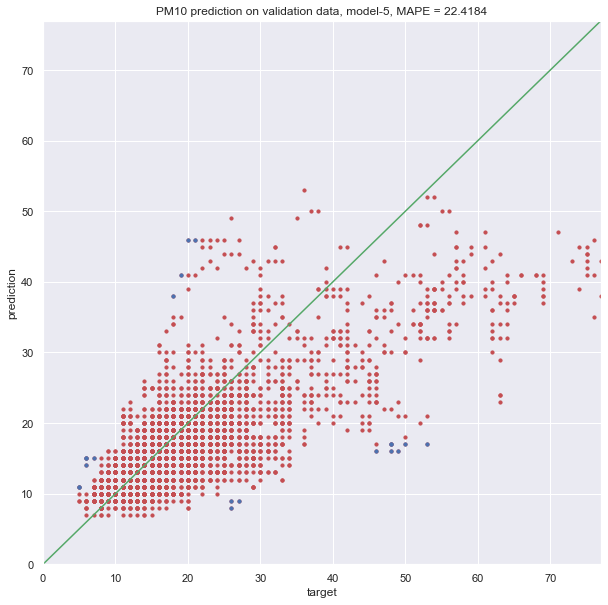

In [44]:
plot_assessment(pred_train_Y, train_Y, title = "training data, model-5")
plot_assessment(pred_val_Y, val_Y, title = "validation data, model-5")

In [45]:
dval = df_val[["Datum", "PM10"]]
dval["Prediction"] = pred_val_Y
dval = dval.set_index(["Datum"]).sort_index()

In [46]:
i = 0

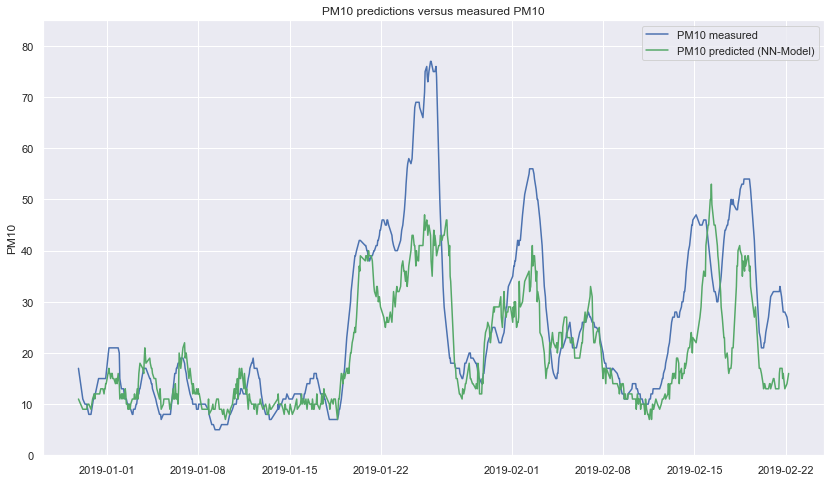

In [47]:
dvali = dval[i:i + 680]

fig = plt.figure(figsize=(14,8))
plt.plot(dvali.index, dvali["PM10"], label='PM10 measured')
plt.plot(dvali.index, dvali["Prediction"], label='PM10 predicted (NN-Model)', color = 'g')
#plt.plot(dval.index, df_val["PM10"], label='Validation')
#plt.plot(errors_df.index, errors_df['pred_qty'], label='Prediction')
plt.ylim(0, 85)
plt.legend(loc='best')
plt.xlabel(' ')
plt.ylabel('PM10')
plt.title('PM10 predictions versus measured PM10')
plt.show()

i += 875
if i > dval.shape[0]:
    i = 0

In [48]:
i = 0

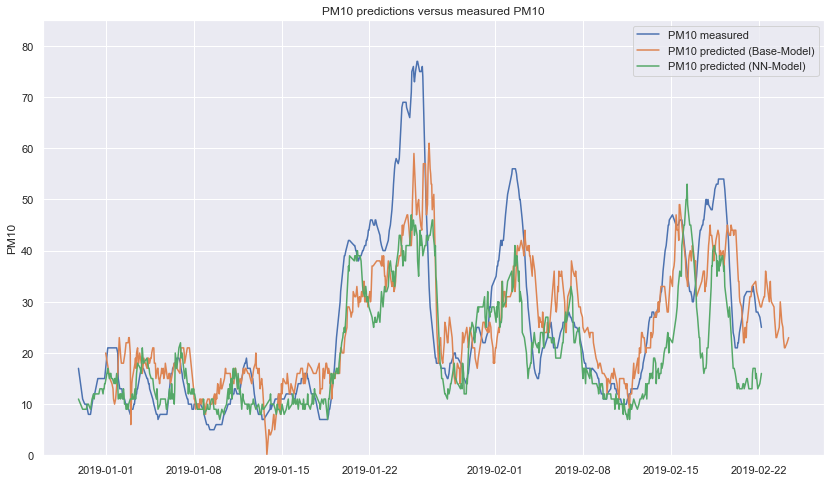

In [49]:
dvali = dval[i:i + 680]
dvali_B = dval_B[i:i + 680]

fig = plt.figure(figsize=(14,8))
plt.plot(dvali.index, dvali["PM10"], label='PM10 measured')
plt.plot(dvali_B.index, dvali_B["Prediction"], label='PM10 predicted (Base-Model)')
plt.plot(dvali.index, dvali["Prediction"], label='PM10 predicted (NN-Model)')
#plt.plot(dval.index, df_val["PM10"], label='Validation')
#plt.plot(errors_df.index, errors_df['pred_qty'], label='Prediction')
plt.ylim(0, 85)
plt.legend(loc='best')
plt.xlabel(' ')
plt.ylabel('PM10')
plt.title('PM10 predictions versus measured PM10')
plt.show()

i += 875
if i > dval.shape[0]:
    i = 0

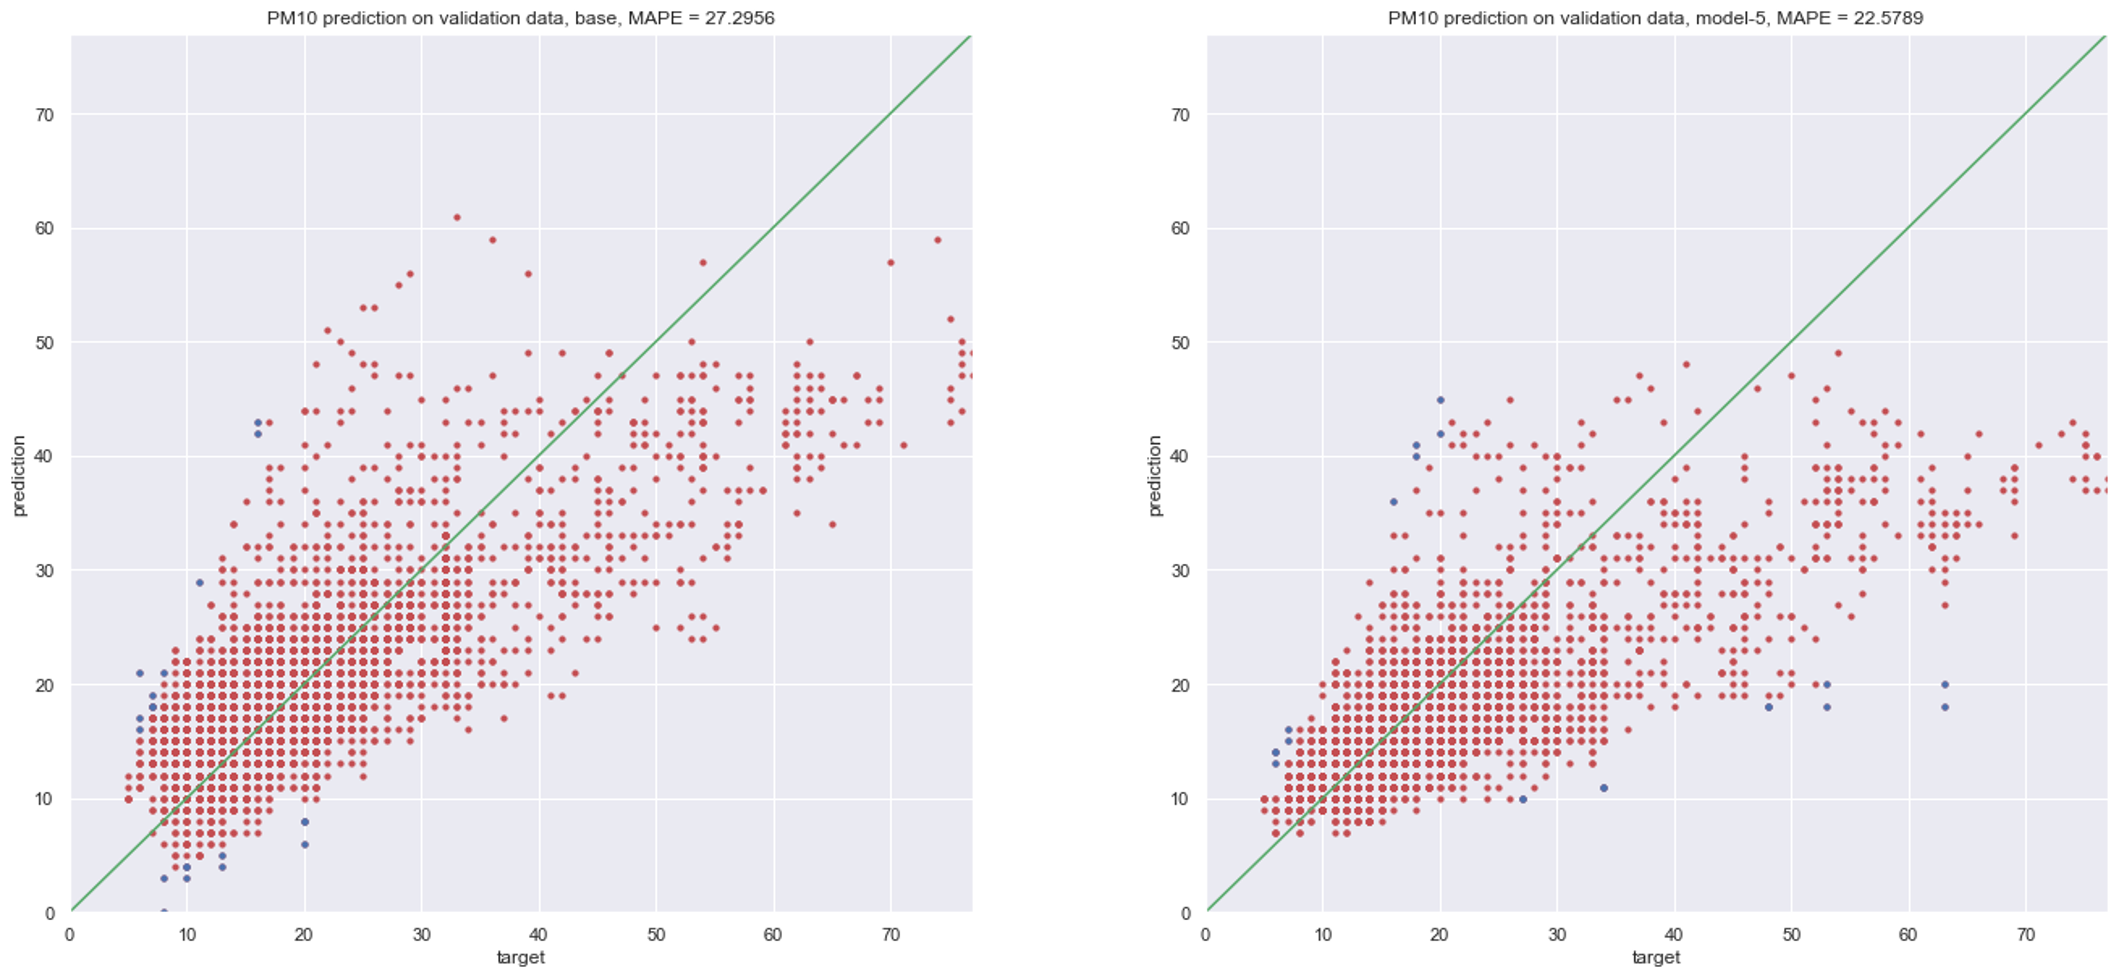

## Applied Optimizations and Improvements

the following points helped to improve the predictions: 

- one-hot encoding
- embeddings
- learning rate  
- learning rate decay
- activation function
- number of nodes  
- number of layers 
- epochs
- normalization layer  
- scaling the output layer to range(0,1)  
- loss function  
- optimizer 
- drop out layer
- shuffle training data (sequence bias) 
- L-1 regularization
- missing data: imputation / dropna

## Ideas for  further Improvement
    - improve imputation, e.g. impute with NN models
    - Convolutional Network
    - RNN
    - LSTM
    - train the model with data up to the day when prediction is launched
    - find additional features
    